## Predict Simulations

Workflow for predicting DZ given a model

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import pickle
from scipy.interpolate import interp1d
import imageio.v2 as imageio
from pathlib import Path
import h5py
from scipy.io import savemat
import scipy.integrate as integrate
from skimage import exposure
from skimage import filters
from scipy import stats
from scipy.io import readsav


from src.data.file_utils import GetEmission, GetPkl
from src.utils.helpers import *

# System Identification
Do this after doing weighted_prediction_ml

In [15]:
value_path = Path('../data/processed/') / 'weight_ml_point'
tv = GetPkl('../data/raw/12_03_2024')
files = tv.list_files(True)

0 	 200970
1 	 200971
2 	 200972
3 	 200973
4 	 200974
5 	 200975
6 	 200976
7 	 200977
8 	 200978
9 	 201072
10 	 201073
11 	 201074
12 	 201075
13 	 201076
14 	 201077
15 	 201078
16 	 201079
17 	 201080
18 	 201081
19 	 201082
20 	 201083
21 	 201084
22 	 201085


In [16]:
# copy the result over to data_fetching on iris
print([int(i.stem.split('_')[-1]) for i in files])

[200970, 200971, 200972, 200973, 200974, 200975, 200976, 200977, 200978, 201072, 201073, 201074, 201075, 201076, 201077, 201078, 201079, 201080, 201081, 201082, 201083, 201084, 201085]


In [181]:
file_idx = 22
shotn = files[file_idx].stem.split('_')[-1]
print(f'Shot {shotn}')

Shot 201085


In [182]:
vid, vid_times = tv.load_processed(files[file_idx])
vid_times *= 1e3

In [183]:
vid_process_1 = np.reshape(vid, (vid.shape[0], -1))
vid_process_2 = normalize_image(vid)
vid_process_2 = np.reshape(vid_process_2, (vid_process_2.shape[0], -1))

In [209]:
h5_path = '../data/external/toksearch/12_03_2024.h5'
shot = str(files[file_idx].stem.split('_')[-1])
with h5py.File(h5_path, 'r') as file:
    
    print(file.keys())
    
    for key in file.keys():
        print(file[key].keys())
        break
    
    h5_times = file['times'][:]
    t_ip_flat_sql = file[shot]['t_ip_flat_sql'][()]
    ip_flat_duration_sql = file[shot]['ip_flat_duration_sql'][()]
    ZXPT1_EFIT01 = file[shot]['ZXPT1_EFIT01'][:]
    RXPT1_EFIT01 = file[shot]['RXPT1_EFIT01'][:]
    tssdivte02 = file[shot]['tssdivte02'][:]
    tssdivte03 = file[shot]['tssdivte03'][:]
    lftdz = file[shot]['lftdz'][:]
    lfsdz = file[shot]['lfsdz'][:]

<KeysViewHDF5 ['200970', '200971', '200972', '200973', '200974', '200975', '200976', '200977', '200978', '201072', '201073', '201074', '201075', '201076', '201077', '201078', '201079', '201080', '201081', '201082', '201083', '201084', '201085', 'spatial_coordinates', 'times']>
<KeysViewHDF5 ['RXPT1_EFIT01', 'ZXPT1_EFIT01', 'gasA', 'gas_sql', 'ip_flat_duration_sql', 'lfsdz', 'lftdz', 't_ip_flat_sql', "tssdivte00'", 'tssdivte01', 'tssdivte02', 'tssdivte03', 'tssdivte04', 'tssdivte05', 'valve_sql']>


In [185]:
coefficients_file = Path('../models/092624_tangtv_v5.txt')
coefficients_1 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_1.append(float(line.strip()))

coefficients_file = Path('../models/weighted_outer_all2_coefficients.txt')
coefficients_2 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_2.append(float(line.strip()))

In [186]:
coef_2_reshape = np.reshape(np.abs(coefficients_2), (vid.shape[1], vid.shape[2])) * 1e7

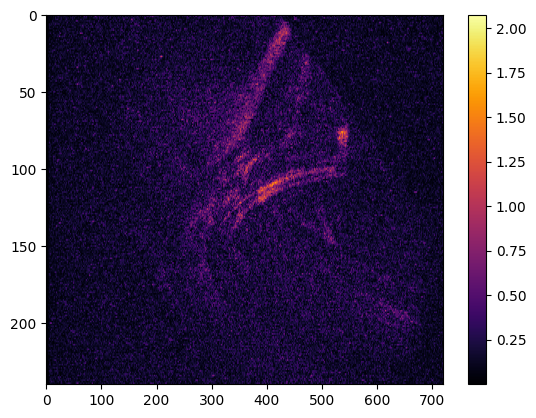

In [187]:
fig, ax = plt.subplots()
img1 = ax.imshow(coef_2_reshape, cmap='inferno')
fig.colorbar(img1, ax=ax)
ax.set_aspect('auto')

In [229]:
prediction_1 = np.dot(vid_process_1, coefficients_1) - 0.916314
prediction_2 = np.dot(vid_process_2 * 255, coefficients_2) - 1.098614

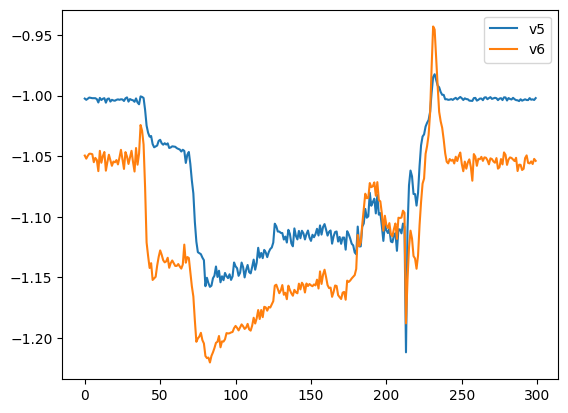

In [230]:
plt.plot(prediction_1, label='v5')
plt.plot(prediction_2, label='v6')
plt.legend()
plt.show()

In [231]:
t_start = 3000#t_ip_flat_sql
t_end = 6000#t_ip_flat_sql + ip_flat_duration_sql
print(t_start, t_end)

t_grid = np.linspace(t_start, t_end, 1000)
crop_h5_times, crop_ZXPT1_EFIT01 = crop_time(h5_times, ZXPT1_EFIT01, t_start, t_end)
crop_vid_times, crop_prediction_1 = crop_time(vid_times, prediction_1, t_start, t_end)
_, crop_prediction_2 = crop_time(vid_times, prediction_2, t_start, t_end)

interp_kind = 'next'
interp_ZXPT = interp1d(crop_h5_times, crop_ZXPT1_EFIT01, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_1 = interp1d(crop_vid_times, crop_prediction_1, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_2 = interp1d(crop_vid_times, crop_prediction_2, kind=interp_kind, fill_value='extrapolate')(t_grid)

# gasA_PID = interp_gasA[0]
interp_ZStrike = np.ones_like(interp_ZXPT) * -1.24477
Dz_1 = 1 - ((interp_ZXPT - interp_prediction_1) / (interp_ZXPT - interp_ZStrike))[0]
Dz_2 = 1 - ((interp_ZXPT - interp_prediction_2) / (interp_ZXPT - interp_ZStrike))[0]

3000 6000


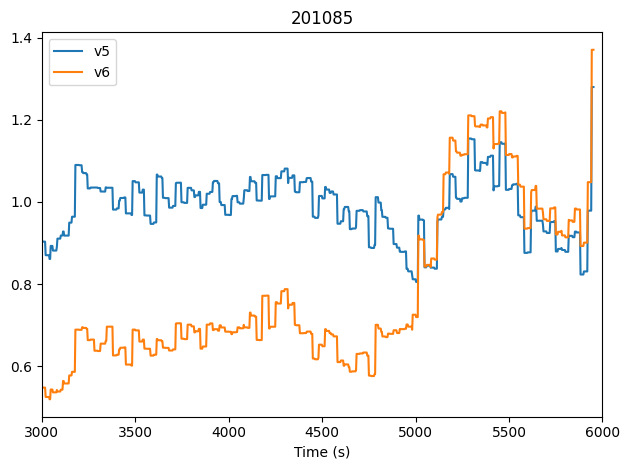

In [232]:
plt.plot(t_grid,Dz_1,label='v5')
plt.plot(t_grid,Dz_2,label='v6')
plt.xlabel('Time (s)')
# plt.ylim(0,1.2)
plt.xlim(t_start,t_end)
plt.legend()
plt.title(shotn)
plt.tight_layout()
plt.show()

In [240]:
st = 4000
detach_idx = nearest_index(t_grid, [st])
attach_idx = nearest_index(t_grid, [4700])
print(Dz_1[detach_idx], Dz_1[attach_idx])
print(Dz_2[detach_idx], Dz_2[attach_idx])
print(np.mean(Dz_2[detach_idx:attach_idx]))

0.9687234059422813 0.9784148798024848
0.6842523193014205 0.6300757067449472
0.6847410710264485


estimated delay:140


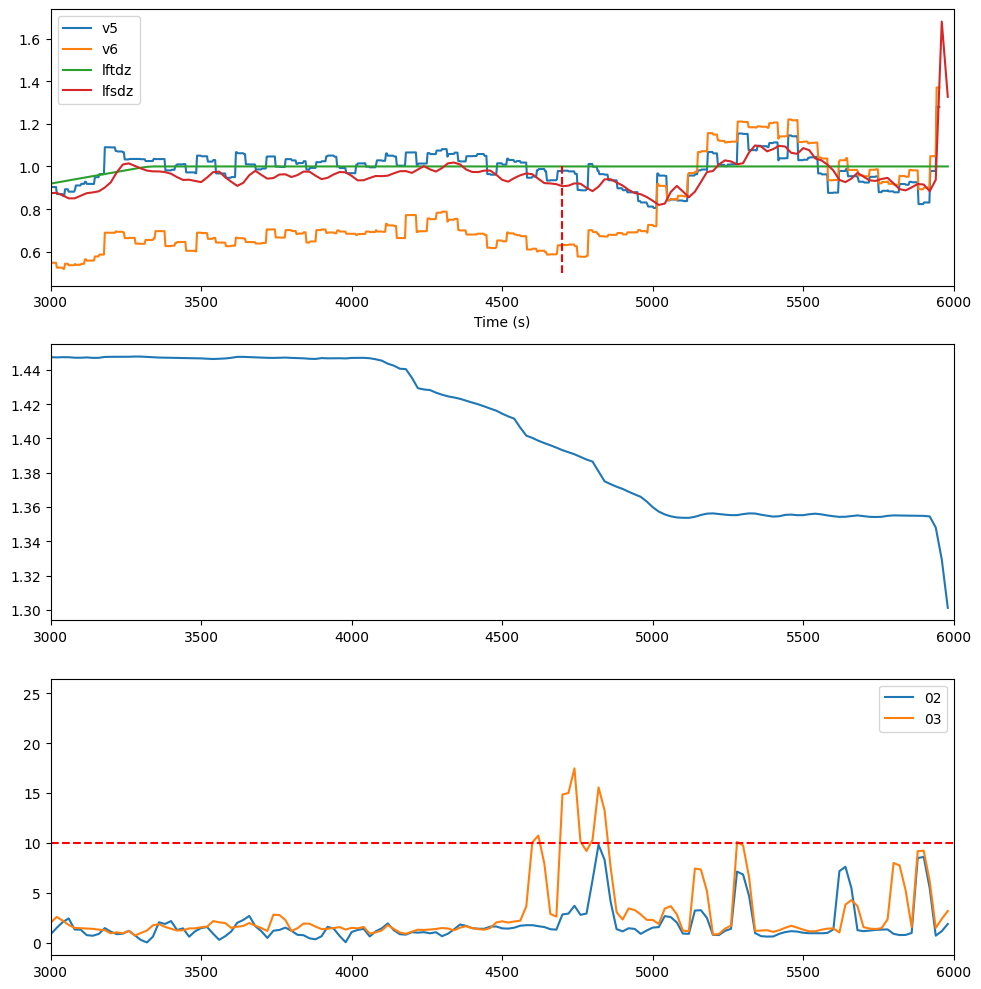

In [239]:
st = 2670
print(f'estimated delay:{2670-2530}')
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(t_grid,Dz_1,label='v5')
plt.plot(t_grid,Dz_2,label='v6')
plt.plot(h5_times,1-lftdz, label='lftdz')
plt.plot(h5_times,1-lfsdz, label='lfsdz')
# plt.vlines([st,st + 1920], .5, 1, color='r', linestyle='--')
plt.vlines([4700], .5, 1, color='r', linestyle='--')
plt.xlim(t_start,t_end)
plt.xlabel('Time (s)')
plt.legend()
plt.subplot(3,1,2)
plt.plot(h5_times, RXPT1_EFIT01)
plt.xlim(t_start,t_end)
plt.subplot(3,1,3)
plt.plot(h5_times, tssdivte02, label='02')
plt.plot(h5_times, tssdivte03, label='03')
plt.xlim(t_start,t_end)
plt.hlines(10, t_start, t_end, color='r', linestyle='--')
# plt.vlines([2530,4450], 0, 20, color='r', linestyle='--')
plt.ylim
plt.legend()
plt.tight_layout()
plt.show()